# Imdb sentiment analysis

In [114]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

01. Import data set

In [115]:
df =  pd.read_csv('finalReviews.csv')
df.head()

,review,label
0,There isn't too much in the way of suspense or...,1
1,"I cried and laughed and blah, blah, blah. CGI ...",1
2,Not as good as infinity war..,1
3,First review from me. This film deserves it. A...,1
4,This film is an emotional rollercoaster with s...,1


In [116]:
x_train,x_test,y_train,y_test = train_test_split(df['review'], df['label'], test_size=0.2, random_state=42)

In [ ]:
import re

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^\w\s.,!?-]', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning to training and test data
x_train = x_train.apply(clean_text)
x_test = x_test.apply(clean_text)

- Use Tokenizer

In [119]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# OPTIMIZED HYPERPARAMETERS (based on data analysis)
max_words = 3000   # Full vocabulary coverage
max_len = 90      # Covers 95% of sequences, balanced model size

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

# Convert text to sequences
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Pad sequences
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len, padding='post')
print(f"Training data shape: {x_train_pad.shape}")


Training data shape: (241, 90)


In [120]:
x_train_pad = np.array(x_train_pad)
x_test_pad = np.array(x_test_pad)

# Prepare labels as arrays
y_train_arr = y_train.values.astype('float32')
y_test_arr = y_test.values.astype('float32')

# Improved model with regularization and dropout to reduce overfitting
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, 64, input_length=max_len),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.2),
    tf.keras.layers.LSTM(32, dropout=0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train model with early stopping
history = model.fit(x_train_pad, y_train_arr, 
                    epochs=25, 
                    validation_split=0.2, 
                    batch_size=32, 
                    verbose=1,
                    callbacks=[early_stopping])


Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.5156 - loss: 0.7765 - val_accuracy: 0.5918 - val_loss: 0.7690
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5469 - loss: 0.7671 - val_accuracy: 0.5918 - val_loss: 0.7579
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5521 - loss: 0.7569 - val_accuracy: 0.5918 - val_loss: 0.7486
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6042 - loss: 0.7572 - val_accuracy: 0.5918 - val_loss: 0.7470
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6302 - loss: 0.7564 - val_accuracy: 0.5918 - val_loss: 0.7439
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6615 - loss: 0.7441 - val_accuracy: 0.6122 - val_loss: 0.7389
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6875 - loss: 0.7297 - val_accuracy: 0.5714 - val_loss: 0.7338
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7031 - loss: 0.7222 - val_accuracy: 0.5918 - val_loss: 0.7262

In [121]:
print("Test Evaluation:")
test_results = model.evaluate(x_test_pad, y_test_arr, verbose=0)
print(f"Test Loss: {test_results[0]:.4f}, Test Accuracy: {test_results[1]:.4f}")


Test Evaluation:
Test Loss: 0.6993, Test Accuracy: 0.6393


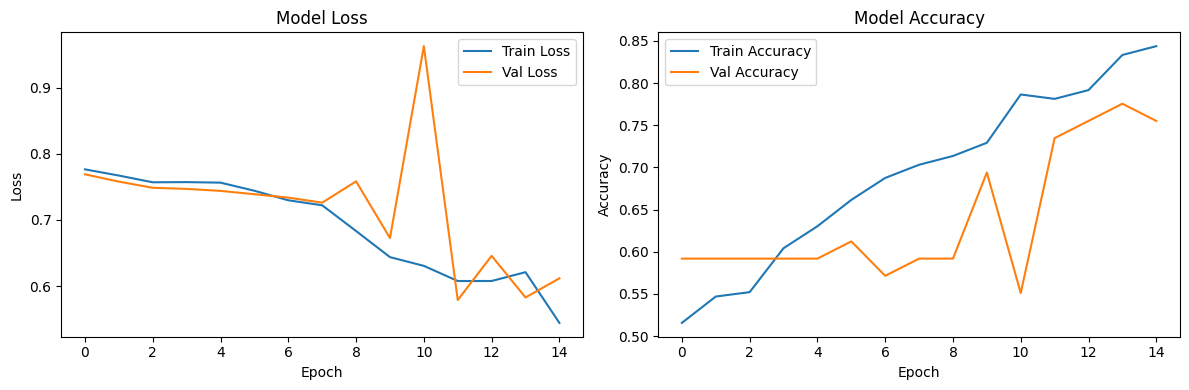

In [122]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.tight_layout()
plt.show()


In [124]:
model.save("sentiment_model.keras")